In [1]:
!pip install python-mnist

In [1]:
import sys, os
WORKING_DIR = None
if os.environ.get('COLAB_GPU', False):
    from google.colab import drive
    drive.mount("/content/drive")
    WORKING_DIR = "/content/drive/My Drive/Colab Notebooks/handwriting"
    sys.path.append(WORKING_DIR)
else:
    WORKING_DIR = "./"

def create_dir(filename):
    try:
        os.mkdir(os.path.dirname(filename))
    except:
        pass
print(WORKING_DIR)

./


# Importing

In [2]:
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import math
from mnist import MNIST

from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.models import load_model
from keras.models import model_from_json

Using TensorFlow backend.


# Parameters

In [3]:
MODEL="0.0.2"

# Data readling and understanding

In [6]:
mndata = MNIST('data')
#This will load the train and test data
train_images_full, train_labels_full = mndata.load(
    'data/emnist/emnist-byclass-train-images-idx3-ubyte',
    'data/emnist/emnist-byclass-train-labels-idx1-ubyte')
test_images_full, test_labels_full = mndata.load(
    'data/emnist/emnist-byclass-test-images-idx3-ubyte',
    'data/emnist/emnist-byclass-test-labels-idx1-ubyte')

In [7]:
# Use small piece of data, remove a-z images
X_train = [e for i, e in enumerate(train_images_full[:30000]) if train_labels_full[i] < 36]
y_train = [e for e in train_labels_full[:30000] if e < 36]
X_test = [e for i, e in enumerate(test_images_full[:10000]) if test_labels_full[i] < 36]
y_test = [e for e in test_labels_full[:10000] if e < 36]

len(X_train), len(y_train), len(X_test), len(y_test)

(22913, 22913, 7681, 7681)

In [8]:
# Convert data to numpy arrays and normalize images to the interval [0, 1]
X_train = np.array(X_train) / 255.0
y_train = np.array(y_train)
X_test = np.array(X_test) / 255.0
y_test = np.array(y_test)

In [9]:
#Reshaping all images into 28*28 for pre-processing
X_train = X_train.reshape(X_train.shape[0], 28, 28)
X_test = X_test.reshape(X_test.shape[0], 28, 28)

Process Complete: Rotated and reversed test and train images!


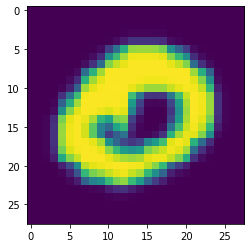

In [10]:
#for train data
for t in range(X_train.shape[0]):
    X_train[t]=np.transpose(X_train[t])

#for test data  
for t in range(X_test.shape[0]):
    X_test[t]=np.transpose(X_test[t])

#checking
plt.imshow(X_test[5])
plt.show

print('Process Complete: Rotated and reversed test and train images!')

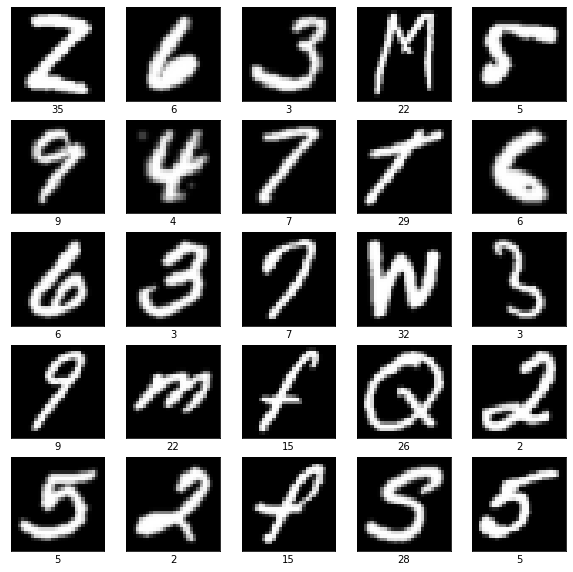

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.xlabel(y_train[i])
plt.show()

# Prepare for tf input

22913
(64, 64, 1)


<function matplotlib.pyplot.show(*args, **kw)>

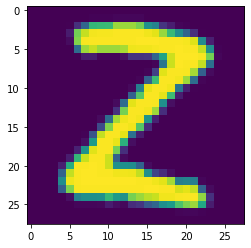

In [12]:
X_train_resized = [tf.image.resize(image.reshape(28,28,1), [64,64]).numpy() for image in X_train]
X_test_resized = [tf.image.resize(image.reshape(28,28,1), [64,64]).numpy() for image in X_test]
print(len(X_train_resized))
print(X_train_resized[0].shape)
plt.imshow(X_train[0])
plt.show

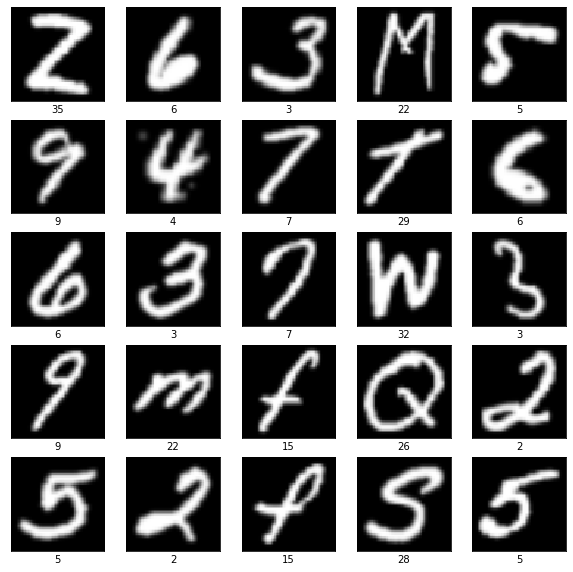

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_resized[i].reshape(64,64), cmap='gray')
    plt.xlabel(y_train[i])
plt.show()

# Modeling

In [13]:
train_images = np.array(X_train_resized).astype('float32')
train_labels = np_utils.to_categorical(y_train, 36)

test_images = np.array(X_test_resized).astype('float32')
test_labels = np_utils.to_categorical(y_test, 36)

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((22913, 64, 64, 1), (22913, 36), (7681, 64, 64, 1), (7681, 36))

In [14]:
print(y_train[0])
print(type(train_labels))
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(dict(zip(unique_elements, counts_elements)))

35
<class 'numpy.ndarray'>
{0: 1462, 1: 1606, 2: 1479, 3: 1437, 4: 1493, 5: 1399, 6: 1512, 7: 1540, 8: 1395, 9: 1439, 10: 247, 11: 160, 12: 444, 13: 203, 14: 193, 15: 403, 16: 116, 17: 150, 18: 517, 19: 148, 20: 111, 21: 202, 22: 378, 23: 357, 24: 1095, 25: 370, 26: 128, 27: 236, 28: 919, 29: 418, 30: 522, 31: 197, 32: 206, 33: 120, 34: 182, 35: 129}


In [0]:
# Create model
if MODEL == '0.0.1':
    model = models.Sequential()
    model.add(layers.Convolution2D(64, (5, 5), 
        activation='relu', input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    
    model.add(layers.BatchNormalization())
    # add fully connected layer
    model.add(layers.Flatten())
    
    model.add(layers.Dense(128, 
        activation='relu', kernel_constraint=maxnorm(3)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(36, activation='softmax'))


In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 60, 60, 64)        1664      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 128)      

# Training

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

In [66]:
#evaluating model on test data. will take time
scores = model.evaluate(test_images,test_labels, verbose = 0)
print("Accuracy: %.2f%%"%(scores[1]*100))

Accuracy: 90.70%


# Saving model

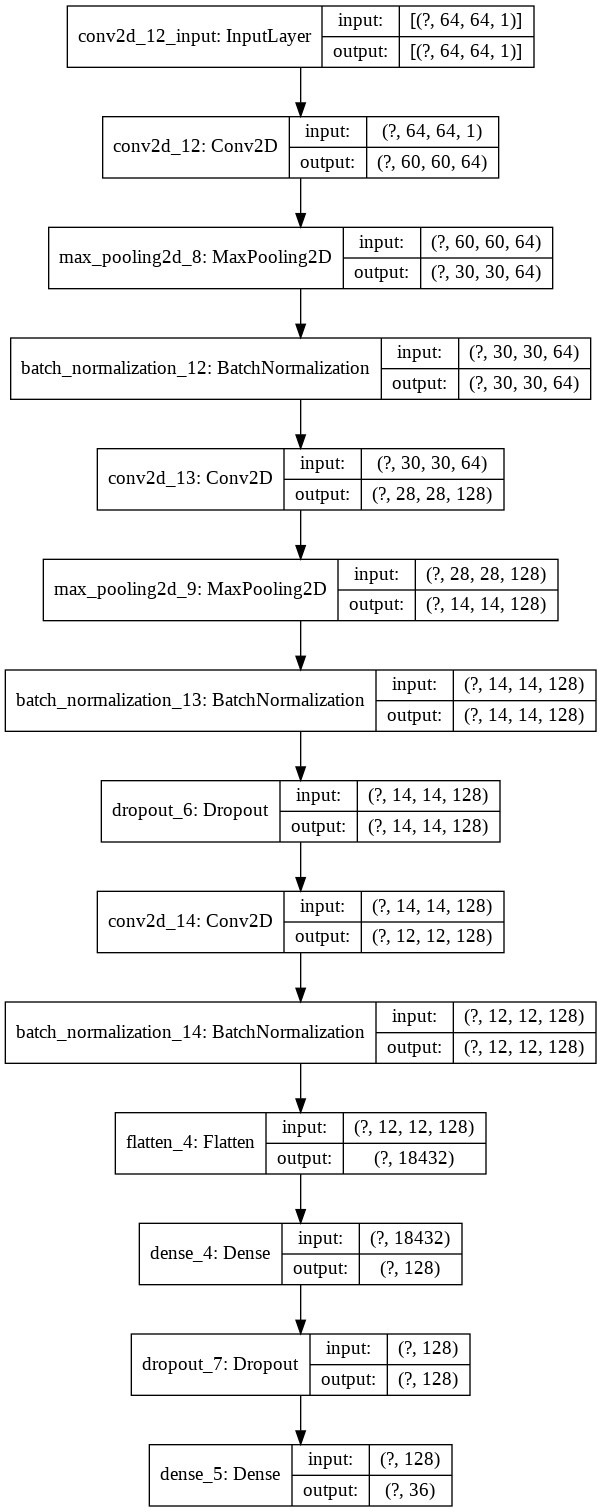

In [63]:
model_json = model.to_json()
output_file = os.path.join(WORKING_DIR,"results/model_{}.json".format(MODEL))
with open(output_file, "w") as json_file:
    json_file.write(model_json)
#saves the model info as json file

output_file = os.path.join(WORKING_DIR,"results/model_{}.h5".format(MODEL))
model.save_weights(output_file, )
# Creates a HDF5 file 'model.h5'

output_file = os.path.join(WORKING_DIR,"results/model_{}_structure.png".format(MODEL))
tf.keras.utils.plot_model(
    model, to_file=output_file, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


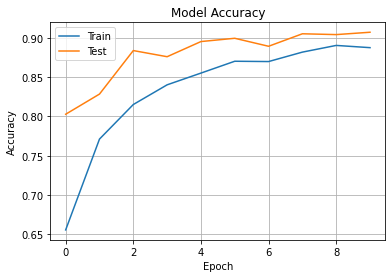

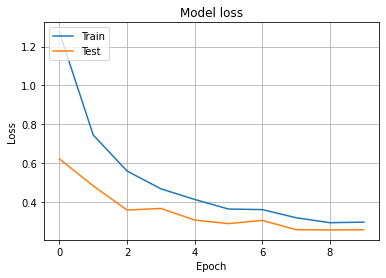

In [33]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
output_file = os.path.join(WORKING_DIR, 'results/model_{}_accuracy.png'.format(MODEL))
create_dir(output_file)
plt.savefig(output_file)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
output_file = os.path.join(WORKING_DIR, 'results/model_{}_loss.png'.format(MODEL))
create_dir(output_file)
plt.savefig(output_file)
plt.show()

# Testing model

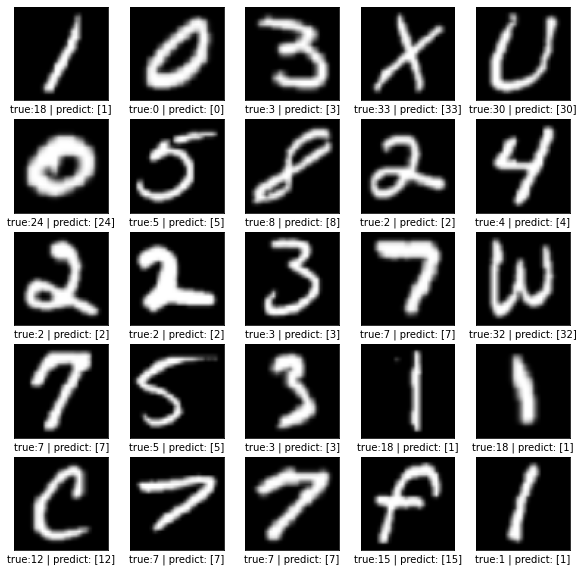

In [56]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_resized[i].reshape(64,64), cmap='gray')
    i_label = model.predict_classes(X_test_resized[i].reshape(1,64,64,1))
    plt.xlabel("true:{} | predict: {}".format(y_test[i], i_label))

output_file = os.path.join(WORKING_DIR,"results/demo_{}.png".format(MODEL))
plt.savefig(output_file)
plt.show()